In [57]:
import json
import os
import random
import shutil
from pathlib import Path

import h5py
import ismrmrd
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import torch
from scipy.io import loadmat, savemat

Selected jpg: output_brats2023_men_01338_t1ce_to_t2_s098_n00875.jpg
Matched mat: /fast_storage/intern/data/instruction_tuning/Instruct_Pix2Pix/crossmodal_mat/test/brats2023_men_01338_t1ce_to_t2_s098_n00875.mat


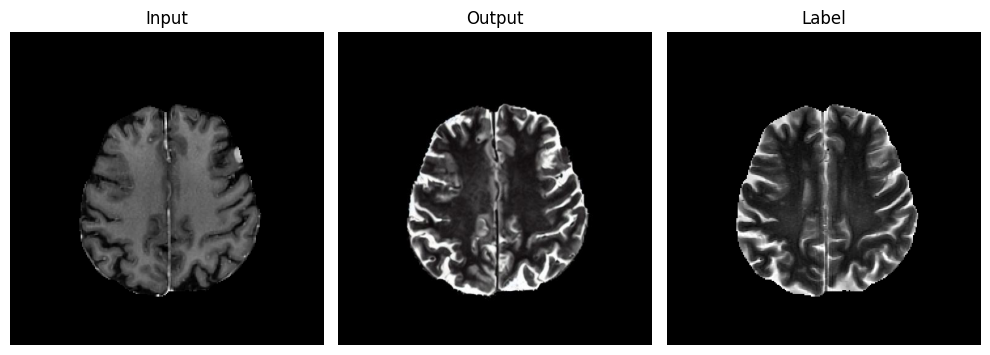

In [229]:
import random
from pathlib import Path
from scipy.io import loadmat
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

jpg_dir = Path("/home/intern4/InstructDiffusion/logs/v0126_5_cmonly_outputs")
mat_dirs = [
    Path("/fast_storage/intern/data/instruction_tuning/Instruct_Pix2Pix/acceleration_mat/test/"),
    Path("/fast_storage/intern/data/instruction_tuning/Instruct_Pix2Pix/crossmodal_mat/test/"),
    Path("/fast_storage/intern/data/instruction_tuning/Instruct_Pix2Pix/denoising_mat/test/"),
    Path("/fast_storage/intern/data/instruction_tuning/Instruct_Pix2Pix/segmentation_mat/test/"),
]

jpg_files = sorted(list(jpg_dir.glob("*.jpg")))
assert jpg_files, f"No jpg files found in {jpg_dir}"
jpg_file = random.choice(jpg_files)
print(f"Selected jpg: {jpg_file.name}")

stem = jpg_file.stem
if stem.startswith("output_"):
    mat_stem = stem[len("output_"):]
else:
    mat_stem = stem
mat_file = None
for mat_dir in mat_dirs:
    candidate = mat_dir / f"{mat_stem}.mat"
    if candidate.exists():
        mat_file = candidate
        break
if mat_file is None:
    raise FileNotFoundError(f"No matching mat file found for {mat_stem} in candidate folders.")
print(f"Matched mat: {mat_file}")

mat_data = loadmat(mat_file)
image_arr = mat_data.get('image', None)
label_arr = mat_data.get('label', None)
if image_arr is None or label_arr is None:
    raise KeyError(f"'image' or 'label' key not found in {mat_file}")

fig, axes = plt.subplots(1, 3, figsize=(10, 4))

jpg_img = Image.open(jpg_file)
axes[1].imshow(jpg_img, cmap='gray')
axes[1].set_title(f"Output")
axes[1].axis('off')

axes[0].imshow(image_arr, cmap='gray')
axes[0].set_title(f"Input")
axes[0].axis('off')

axes[2].imshow(label_arr, cmap='gray')
axes[2].set_title(f"Label")
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [181]:
from pathlib import Path
from scipy.io import loadmat
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr

jpg_dir = Path("/home/intern4/InstructDiffusion/logs/v0126_9_acconly_outputs")
mat_dirs = [
    Path("/fast_storage/intern/data/instruction_tuning/Instruct_Pix2Pix/acceleration_mat/test/"),
    Path("/fast_storage/intern/data/instruction_tuning/Instruct_Pix2Pix/crossmodal_mat/test/"),
    Path("/fast_storage/intern/data/instruction_tuning/Instruct_Pix2Pix/denoising_mat/test/"),
    Path("/fast_storage/intern/data/instruction_tuning/Instruct_Pix2Pix/segmentation_mat/test/")
]

def dice_score(mask1, mask2):
    # mask1, mask2: binary numpy arrays
    intersection = np.logical_and(mask1, mask2).sum()
    return 2. * intersection / (mask1.sum() + mask2.sum() + 1e-8)

jpg_files = sorted(list(jpg_dir.glob("*.jpg")))
ssim_list = []
psnr_list = []
dice_list = []
matched_count = 0

for jpg_file in jpg_files:
    stem = jpg_file.stem
    if stem.startswith("output_"):
        mat_stem = stem[len("output_"):]
    else:
        mat_stem = stem
    mat_file = None
    for mat_dir in mat_dirs:
        candidate = mat_dir / f"{mat_stem}.mat"
        if candidate.exists():
            mat_file = candidate
            break
    if mat_file is None:
        print(f"No matching mat file for {mat_stem}")
        continue

    mat_data = loadmat(mat_file)
    label_arr = mat_data.get('label', None)
    if label_arr is None:
        print(f"'label' key not found in {mat_file}")
        continue

    jpg_img = Image.open(jpg_file).convert('L')
    label_arr = np.array(label_arr, dtype=np.float32)
    
    # Shape이 다르면 jpg를 label shape에 맞게 리사이즈
    if jpg_img.size[::-1] != label_arr.shape:
        target_height, target_width = label_arr.shape
        jpg_img = jpg_img.resize((target_width, target_height), Image.Resampling.LANCZOS)
        print(f"Resized {jpg_file.name} to {label_arr.shape}")
    
    jpg_arr = np.array(jpg_img, dtype=np.float32)

    if np.isnan(jpg_arr).any() or np.isnan(label_arr).any() or np.isinf(jpg_arr).any() or np.isinf(label_arr).any():
        print(f"NaN or inf in {jpg_file.name} or {mat_file.name}")
        continue

    drange = label_arr.max() - label_arr.min()
    if drange == 0:
        print(f"data_range=0 for {jpg_file.name} vs {mat_file.name}")
        continue

    # SSIM, PSNR
    ssim_val = ssim(jpg_arr, label_arr, data_range=drange)
    psnr_val = psnr(jpg_arr, label_arr, data_range=drange)
    ssim_list.append(ssim_val)
    psnr_list.append(psnr_val)

    # Dice score: 0이 아닌 영역을 모두 1로 binarize
    jpg_bin = (jpg_arr > 0).astype(np.uint8)
    label_bin = (label_arr > 0).astype(np.uint8)
    dice = dice_score(jpg_bin, label_bin)
    dice_list.append(dice)
    matched_count += 1

if matched_count > 0:
    print(f"Matched files: {matched_count}")
    print(f"SSIM mean: {np.mean(ssim_list):.4f}")
    print(f"PSNR mean: {np.mean(psnr_list):.4f}")
    print(f"Dice mean: {np.mean(dice_list):.4f}")
else:
    print("No matched files found.")

Resized output_fastmri_701555790047_t1_r8_s009_n04341.jpg to (256, 208)
Resized output_fastmri_702078924248_t2_r8_s008_n04348.jpg to (768, 768)
Resized output_fastmri_708265024589_t1ce_r6_s008_n04394.jpg to (512, 464)
Resized output_fastmri_715038400502_t1ce_r8_s002_n04433.jpg to (256, 208)
Resized output_fastmri_716826749958_t1_r4_s005_n04449.jpg to (512, 408)
Resized output_fastmri_716848184845_t2_r6_s012_n04450.jpg to (384, 348)
Resized output_fastmri_725273345184_flair_r8_s003_n04523.jpg to (256, 256)
Resized output_fastmri_739222125234_t2_r4_s003_n04610.jpg to (512, 416)
Resized output_fastmri_740239372422_t1ce_r2_s011_n04621.jpg to (256, 208)
Resized output_fastmri_741336885249_t2_r8_s011_n04633.jpg to (768, 768)
Resized output_fastmri_742224458962_t2_r2_s009_n04640.jpg to (384, 336)
Resized output_fastmri_756888700874_t1ce_r2_s003_n04744.jpg to (320, 320)
Resized output_fastmri_759094965403_t1_r4_s008_n04767.jpg to (256, 208)
Resized output_fastmri_761725903804_t1_r8_s006_n04785

In [ ]:
import random
from pathlib import Path
from scipy.io import loadmat
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# 1. 폴더 설정
jpg_dir = Path("/home/intern4/InstructDiffusion/logs/only_seg")  # jpg 파일이 있는 폴더
mat_dirs = [
    Path("/fast_storage/intern/data/instruction_tuning/IP_Adapter/acceleration_mat/test/"),
    Path("/fast_storage/intern/data/instruction_tuning/IP_Adapter/crossmodal_mat/test/"),
    Path("/fast_storage/intern/data/instruction_tuning/IP_Adapter/denoising_mat/test/"),
    Path("/fast_storage/intern/data/instruction_tuning/IP_Adapter/segmentation_mat/test/")
]

# 2. jpg 파일 중 임의로 한 장 선택
jpg_files = sorted(list(jpg_dir.glob("*.jpg")))
assert jpg_files, f"No jpg files found in {jpg_dir}"
jpg_file = random.choice(jpg_files)
print(f"Selected jpg: {jpg_file.name}")

# 3. 매칭되는 mat 파일 찾기 (jpg 파일명에서 확장자 제거)
stem = jpg_file.stem
mat_file = None
for mat_dir in mat_dirs:
    candidate = mat_dir / f"{stem}.mat"
    if candidate.exists():
        mat_file = candidate
        break
if mat_file is None:
    raise FileNotFoundError(f"No matching mat file found for {stem} in candidate folders.")
print(f"Matched mat: {mat_file}")

# 4. mat 파일에서 image, label 키 추출
mat_data = loadmat(mat_file)
image_arr = mat_data.get('image', None)
label_arr = mat_data.get('label', None)
if image_arr is None or label_arr is None:
    raise KeyError(f"'image' or 'label' key not found in {mat_file}")

# 5. jpg, image, label 모두 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# jpg
jpg_img = Image.open(jpg_file)
axes[0].imshow(jpg_img, cmap='gray')
axes[0].set_title(f"JPG: {jpg_file.name}")
axes[0].axis('off')

# mat image
axes[1].imshow(image_arr, cmap='gray')
axes[1].set_title(f"MAT image\nShape: {image_arr.shape}")
axes[1].axis('off')

# mat label
axes[2].imshow(label_arr, cmap='gray')
axes[2].set_title(f"MAT label\nShape: {label_arr.shape}")
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import random
from scipy.io import loadmat
from pathlib import Path
import matplotlib.pyplot as plt

mat_dir = Path("/fast_storage/intern/data/instruction_tuning/identity_mat/train")  # jpg 파일이 있는 폴더


mat_files = sorted(list(mat_dir.glob("*.mat")))
assert mat_files, f"No mat files found in {mat_dir}"
mat_file = random.choice(mat_files)
print(f"Loading: {mat_file.name}")

mat_data = loadmat(mat_file)
print(f"\nAll keys in .mat file:")
for key in mat_data.keys():
    print(f"  - {key}")

print("\n" + "="*60)
print("Data keys with content:")
print("="*60)

data_keys = [k for k in mat_data.keys() if not k.startswith('__')]

# Separate image keys from other keys
image_keys = []
other_keys = []

for key in data_keys:
    if key in ['image', 'label'] and len(mat_data[key].shape) == 2:
        image_keys.append(key)
    else:
        other_keys.append(key)

# Print non-image data
for key in other_keys:
    print(f"\nKey: '{key}'")
    print(f"  Type: {type(mat_data[key])}")
    print(f"  Shape: {mat_data[key].shape}")
    print(f"  Dtype: {mat_data[key].dtype}")
    
    # Print content based on type
    if mat_data[key].dtype.kind in ['U', 'S', 'O']:  # String types
        print(f"  Content (string):")
        content_str = str(mat_data[key])
        if len(content_str) > 500:
            print(f"    {content_str[:500]}...")
            print(f"    (truncated, total length: {len(content_str)})")
        else:
            print(f"    {content_str}")
    elif mat_data[key].size < 20:  # Small arrays
        print(f"  Content (full):")
        print(f"    {mat_data[key]}")
    else:  # Large arrays
        print(f"  Content (stats):")
        print(f"    Min: {mat_data[key].min():.4f}")
        print(f"    Max: {mat_data[key].max():.4f}")
        print(f"    Mean: {mat_data[key].mean():.4f}")
        print(f"    Std: {mat_data[key].std():.4f}")

# Visualize image data
if image_keys:
    num_images = len(image_keys)
    fig, axes = plt.subplots(1, num_images, figsize=(6*num_images, 6))
    if num_images == 1:
        axes = [axes]
    
    for idx, key in enumerate(image_keys):
        print(f"\nKey: '{key}'")
        print(f"  Type: {type(mat_data[key])}")
        print(f"  Shape: {mat_data[key].shape}")
        print(f"  Dtype: {mat_data[key].dtype}")
        print(f"  Min: {mat_data[key].min():.4f}, Max: {mat_data[key].max():.4f}")
        print(f"  Mean: {mat_data[key].mean():.4f}, Std: {mat_data[key].std():.4f}")
        
        axes[idx].imshow(mat_data[key], cmap='gray')
        axes[idx].set_title(f"'{key}'\nShape: {mat_data[key].shape}")
        axes[idx].axis('off')
    
    plt.tight_layout()

    print(mat_data['instruction'])
    plt.show()
